<p align="center"><img src="WHU.png" alt="武汉大学校徽"/></p>
<p align="center"><font size="7">实验报告</font></p>

# 神经网络可视化实验
专业: 临床医学(八年制)  
班级: 3班  
姓名: 闻人星湘  
指导教师: 王翀  

## 实验环境说明与实验准备
本地实验的配置信息如下:
1. 该实验所使用的操作系统为 Ubuntu 24.04 LTS, CPU 为 AMD RYZEN 5000 Series 7, GPU 为 Geforce RTX 3050.
2. 该实验使用的 Python 版本为 3.12.3, CUDA Toolkit 版本为 12.4, cuDNN 版本为 9.8, [Pytorch](https://pytorch.org/) 版本为 2.6.

云端实验的配置信息如下:  
&emsp;&emsp;该实验所使用的浏览器为 Firefox, 浏览器中使用 [TensorFlow Playground](https://playground.tensorflow.org/) 进行探究.

以下为预导入所需要的库以及准备训练网络所需要的数据:

In [ ]:
# 导入需要的标准库
from functools import partial
from typing import Tuple, Callable

# 导入需要的第三方库
import torch
import pandas as pd
from torch import nn
import seaborn as sns
from sklearn.datasets import make_circles
from torch.utils.data import DataLoader, Dataset, random_split

# 根据实际情况选择训练硬件
device = torch.accelerator.current_accelerator().type \
    if torch.accelerator.is_available() else "cpu"
print(f"使用{device}训练模型.")

使用cuda训练模型.


以下是本地实验所用的数据集:


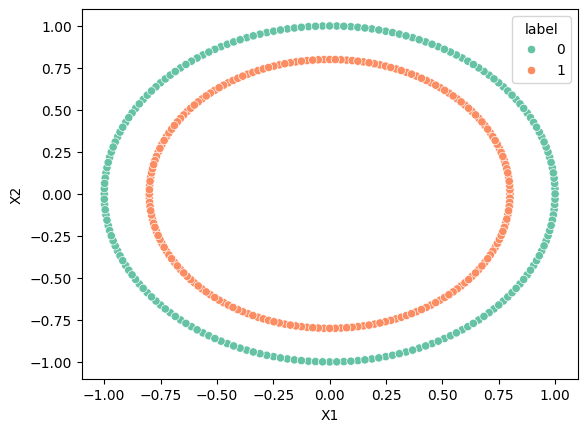

In [ ]:
# 随机生成数据, 内圆和外圆各 200 个点
X, y = make_circles(400)
# 将数据转换为 PyTorch 张量
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# 将数据转换为 DataFrame 以便使用 seaborn
pd_data = pd.DataFrame(X.numpy(), columns=["X1", "X2"])
pd_data["label"] = y.numpy()
# 绘制散点图
print("以下是本地实验所用的数据集:")
sns.scatterplot(
    data=pd_data, x="X1", y="X2", hue="label", palette="Set2"
)

# 定义用于该问题的数据集类
class CircleDataset(Dataset):
    def __init__(self, X, y):
        """圆形数据集的数据加载器"""
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return X[index], y[index]

# 初始化数据集并划分训练集和测试集
circle_dataset = CircleDataset(X, y)
train_dataset, test_dataset = random_split(circle_dataset, [200, 200])
# 初始化训练集和测试集的数据加载器
train_loader = DataLoader(train_dataset, batch_size=10)
test_loader = DataLoader(test_dataset, batch_size=10)


## 实验目标
1. 理解神经网络的基本结构: 了解神经网络的层(Layer), 包括输入层(Iuput Layer), 隐藏层(Hidden Layer), 输出层(Output Layer); 了解神经网络的激活函数(Activation Function), 包括但不限于线性整流函数(ReLU), 双曲正切函数(Tanh), S型函数(Sigmoid), 归一化指数函数(Softmax)等. 学会合理配置神经网络层数以及每层神经元数.
2. 观察神经网络的训练过程: 了解损失函数(Loss Function), 参数更新策略(Parameter Update Strategy), 学习率(Learning Rate), 前向传播(Forward), 反向传播(Backward), 批大小(Batch Size), 训练轮数(Epoch), 正则化(Regularization)的概念, 学会通过损失曲线(Loss Curve)判断网络是否在学习.
3. 掌握神经网络的超参数调优: 学会调整学习率, 理解它对训练速度的影响; 尝试不同激活函数, 观察分类效果的变化; 了解如何通过正则化防止模型过拟合.
4. 理解神经网络能解决的问题类型: 通过不同数据集(如圆形分布, 螺旋分布等)，理解神经网络如何分类复杂数据, 学会通过添加特征(如$X^2$​, $\sin(x)$等​)提升模型性能.
5. 培养动手实践和问题解决能力: 通过调整参数和结构，完成分类任务挑战; 学会分析实验结果，提出改进方案.

## 实验具体内容

### 初识神经网络
&emsp;&emsp;实验设置: 使用圆形分布数据集, 设置学习率为 0.03, 激活函数为 Tanh, 隐藏层为 1 层 4 个神经元.  
&emsp;&emsp;实验结果如下:
<img src="First.png" alt="初识神经网络">

&emsp;&emsp;可以观察到, 背景颜色原本为无色(还未开始训练), 而后迅速变为橙色包裹蓝色, 蓝色朝某个方向开口, 随着迭代次数增加, 蓝色迅速闭合. 分类前后明显可以在背景颜色和数据点(Sample)的位置关系看到差异: 训练前背景和颜色没有显著差异, 训练结束后数据点和背景对应得很好.  
&emsp;&emsp;损失曲线均呈S型, 初期和末期下降速度慢, 中期下降较快, 但整体来看损失曲线几乎没有下降较慢的过程, 只有在一开始训练的时候才可以观察到. 训练结束后训练数据上的损失和测试数据上的损失差异很小(0.01)且均较低, 这表明模型有良好的泛化能力, 但是数据集和模型非常简单(没有噪声的引入, 隐藏层数量和神经元数量小等等), 所以该模型并不具有实际应用价值.  
&emsp;&emsp;分类效果图和损失曲线反映了模型学习的实时状态, 两者在反映模型学习情况上相互补充, 我们可以根据两者及时地调整模型.  
&emsp;&emsp;若损失没有降到 0.01 以下, 说明模型拟合能力不足(在该次子实验中几乎不会出现), 从数据集和模型本身来看, 有以下几点原因:

1. 模型过于简单
2. 特征工程不足
3. 训练时间不足
4. 数据量不足
5. 正则化过度
6. 学习率设置不当
7. 数据质量问题
8. 优化算法选择不当

&emsp;&emsp;如果该模型真的出现了这个问题, 在这个实验中最可能的是由于深度模型只能得到局部最优解, 而不是全局最优解, 局部最优解并不一定是全局最优解, 模型最终拟合到了一个非全局最优解的局部最优解上, 随机参数初始化过程导致了这个问题.  
&emsp;&emsp;以下是复现网站上模型的代码, 其中有一个区别是学习率并不固定, 根据测试损失实时调整[测试损失高于 0.2 时为 0.3, 低于 0.01 时为 0.003(此次实验不会用到), 其他时候为 0.03], 观察输出可以看出模型的运行情况:

In [ ]:
def train_process(
    dataloader: DataLoader, model: nn.Sequential,
    loss_fn: nn.CrossEntropyLoss, optimizer: torch.optim.SGD
) -> float:
    """训练过程
    
    :param dataloader: 训练数据加载器
    :type dataloader: torch.utils.data.DataLoader
    :param model: 模型
    :type model: torch.nn.Sequential
    :param loss_fn: 损失函数
    :type loss_fn: torch.nn.CrossEntropyLoss
    :param optimizer: 优化器
    :type optimizer: torch.optim.SGD
    :return: 训练损失
    :rtype: float
    """
    # 设置模型为训练模式
    model.train()
    # 初始化训练损失
    train_loss = 0
    # 遍历数据集
    for batch, (X, y) in enumerate(dataloader):
        # 将数据移动到训练硬件上
        X, y = X.to(device), y.to(device)
        # 使用模型获取预测值并计算损失(前向传播过程)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        # 反向传播
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新参数
        optimizer.zero_grad()  # 清空梯度
    # 返回该次的平均损失
    return train_loss / len(dataloader)

def test_process(
    dataloader: DataLoader, model: nn.Sequential,
    loss_fn: nn.CrossEntropyLoss
) -> Tuple[float, float]:
    """测试过程
    
    :param dataloader: 测试数据加载器
    :type dataloader: torch.utils.data.DataLoader
    :param model: 模型
    :type model: torch.nn.Sequential
    :param loss_fn: 损失函数
    :type loss_fn: torch.nn.CrossEntropyLoss
    :return: 测试损失和准确率
    :rtype: Tuple[float, float]
    """
    # 设置模型为评估模式
    model.eval()
    # 初始化测试损失和正确数
    test_loss, correct = 0, 0
    # 不计算梯度
    with torch.no_grad():
        # 遍历数据集
        for X, y in dataloader:
            # 将数据移动到训练硬件上
            X, y = X.to(device), y.to(device)
            # 使用模型获取预测值并计算损失
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 计算该批次中的正确数量并累加到 correct 中
            correct += (pred.argmax(1) == y) \
                .type(torch.float).sum().item()
    return test_loss / len(dataloader), \
        correct / len(dataloader.dataset)

def train(
    epochs: int, model: nn.Sequential, lr: float,
    dynamic_lr: bool = True, shutdown: bool = False, 
    callback: Callable[[int, float, float, float], None] \
        = lambda a, b, c, d: None
):
    """训练模型
    
    :param epochs: 训练的 epochs 数
    :type epochs: int
    :param model: 模型
    :type model: torch.nn.Sequential
    :param lr: 学习率
    :type lr: float
    :param dynamic_lr: 是否使用动态学习率
    :type dynamic_lr: bool
    :param shutdown: 是否在测试损失低于 0.01 提前终止训练
    :type shutdown: bool
    :param callback: 回调函数, 用于实时追踪训练情况, 输入参数分别为迭代次数, 
        训练损失, 测试损失, 测试准确率
    :type callback: Callable[[int, float, float, float], None]
    """
    # 实验只有分类任务, 所以所有次的实验都使用交叉熵损失作为损失函数
    loss_fn = nn.CrossEntropyLoss()
    # 所有实验都使用随机梯度下降作为优化策略
    high_rate_optimizer = torch.optim.SGD(
        model.parameters(), lr=lr*10
    )
    usual_opotimizer = torch.optim.SGD(
        model.parameters(), lr=lr
    )
    low_rate_optimizer = torch.optim.SGD(
        model.parameters(), lr=lr/10
    )
    # 初始化循环时要存储状态的变量
    optimizer = high_rate_optimizer if dynamic_lr else usual_opotimizer
    test_loss = 1
    # 训练 epochs 次
    for t in range(epochs):
        # 如果使用动态学习率
        if dynamic_lr:
            # 则根据测试损失动态调整学习率
            if test_loss < 0.01:
                optimizer = low_rate_optimizer
            elif test_loss > 0.2:
                optimizer = high_rate_optimizer
            else:
                optimizer = usual_opotimizer
        # 训练和测试模型
        train_loss = train_process(
            train_loader, model, loss_fn, optimizer
        )
        test_loss, test_acc = test_process(test_loader, model, loss_fn)
        # 调用回调函数, 以实时追踪训练情况
        callback(t + 1, train_loss, test_loss, test_acc)
        # 如果 shutdown 为 True, 并且测试损失小于 0.01, 则提前终止训练
        if shutdown and test_loss < 0.01:
            return train_loss, test_loss, t + 1
    # 返回训练和测试损失, 以及训练的 epochs 数
    return train_loss, test_loss, epochs

def _print(
    epochs: int, train_loss: float, test_loss: float,
    test_acc: float, every_epoch: int = 10
):
    # 打印训练和测试损失, 以及测试准确率
    if epochs % every_epoch == 0:
        print(
            f"epoch {epochs}, train loss: {train_loss:.4f}, "
            f"test loss: {test_loss:.4f}, test acc: {test_acc:.4f}"
        )

In [ ]:
# 构建最简单的模型
first_model = nn.Sequential(
    nn.Linear(2, 4), nn.Tanh(),
    nn.Linear(4, 4), nn.Tanh(),
    nn.Linear(4, 2)
).to(device)

# 训练模型并输出训练过程和最终结果
train_loss, test_loss, epochs = train(
    5000, first_model, 0.03, shutdown=True,
    callback=partial(_print, every_epoch=50)
)
print(
    f"epoch {epochs}, train loss: {train_loss}, "
    f"test loss: {test_loss}"
)

epoch 50, train loss: 0.4885, test loss: 0.4654, test acc: 0.8400
epoch 100, train loss: 0.3044, test loss: 0.3156, test acc: 0.8050
epoch 150, train loss: 0.2155, test loss: 0.2760, test acc: 0.8800
epoch 200, train loss: 0.3283, test loss: 0.3258, test acc: 0.8650
epoch 250, train loss: 0.0501, test loss: 0.0588, test acc: 1.0000
epoch 300, train loss: 0.0256, test loss: 0.0295, test acc: 1.0000
epoch 350, train loss: 0.0156, test loss: 0.0179, test acc: 1.0000
epoch 400, train loss: 0.0107, test loss: 0.0123, test acc: 1.0000
epoch 435, train loss: 0.0086, test loss: 0.0100


### 探索学习率对训练速度的影响
以下为在网站中运行得到的数据:
| 实验序号 | 学习率 | 测试损失达到 0.01 时的 epoch 数 |
| :-: | :-: | :-: |
| 1 | 0.003 | 约 5500 |
| 2 | 0.03 | 846 |
| 3 | 0.1 | 127 |
| 4 | 1 | (模型无法稳定) |

&emsp;&emsp;从表中可以看出, 学习率与训练所需轮数大致成反比, 但学习率过高会导致模型无法收敛: 损失曲线一直在波动, 无法平稳, 分类效果比较差. 这说明模型的学习率设置不合理或者 Batch 大小不合理, 不能很好地匹配给定的学习率.  
&emsp;&emsp;但是请注意: 学习率不能太小, 这会导致模型需要很多轮才能收敛, 从而很好地拟合数据.  
&emsp;&emsp;以下是寻找最好学习率的代码, 若到 1500 轮测试损失都不能小于 0.01, 则模型被认为不能及时收敛. 为防止出现上述讨论的问题, 我们仅探讨学习率区间 0.01-0.20, 我们假定这个区间的测试损失单调递减, 运行结果见下方代码输出:

In [ ]:
def detect_lr():
    """寻找可行的学习率区间示例函数"""
    # 遍历 20 个学习率
    for i in range(20):
        # 依据遍历次数计算学习率
        lr = (i+1)*0.01
        
        # 构建模型
        model = nn.Sequential(
            nn.Linear(2, 4), nn.Tanh(),
            nn.Linear(4, 4), nn.Tanh(),
            nn.Linear(4, 2)
        ).to(device)
        
        # 训练模型并返回训练损失, 测试损失和 epochs
        train_loss, test_loss, epochs = train(
            5000, model, lr, False, True
        )
        
        # 将学习率和 epochs 返回
        yield lr, epochs

# 检测学习率: 只记录 epochs 大于 200 小于 500 时的学习率, 其他情况的学习率都为 0
lr_buffer = [
    lr if 200 < epochs < 500 else 0
    for lr, epochs in detect_lr()
]
# 过滤掉为 0 的学习率
lr_buffer = list(filter(lambda x: x != 0, lr_buffer))
# 将学习率转换为字符串以便输出
lr_buffer = list(map(str, lr_buffer))

print(f"轮次大于200小于500的学习率有: {', '.join(lr_buffer)}.")
print(f"可行的学习率区间为: {min(lr_buffer)} - {max(lr_buffer)}.")

轮次大于200小于500的学习率有: 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.16, 0.17.
可行的学习率区间为: 0.05 - 0.17.


### 探索激活函数对训练的影响
以下是在网站上使用不同的激活函数运行得到的结果:
| 实验序号 | 中文名 | 英文名 | 公式 | 适用任务类型 | 训练轮次 |
| :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | 线性整流函数 | ReLU | $\text{ReLU}(x) = \max(0, x)$ | 深度神经网络隐藏层、回归与分类任务 | 256 |
| 2 | 双曲正切函数 | Tanh | $\text{Tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | 浅层网络、RNN、需要归一化输出的任务 | 1685 |
| 3 | S型函数 | Sigmoid | $\text{Sigmoid}(x) = \frac{1}{1 + e^{-x}}$ | 二分类任务输出层、概率建模 | 2723 |
| 4 | 归一化指数函数 | Softmax | $\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$ | 多分类任务输出层、概率分布建模 | (网站上无该激活函数) |

<img src="Second_1.png" alt="ReLU函数训练结果">
<img src="Second_3.png" alt="Sigmoid函数训练结果">

&emsp;&emsp;由以上结果可以看出, 线性整流函数的边界最不光滑, 棱角分明, 双曲正切函数和S型函数的边界形状比较接近, 没有明显的棱角, 而是表现为一段弧度, 对于圆形数据集而言, 双曲正切函数是一个比较好的选择, 因为线性整流函数明显存在棱角, 而S型函数训练速度偏慢.  
&emsp;&emsp;在训练轮次上, 显然 ReLU \< Tanh \< Sigmoid, 从函数图形上可以看出, Tanh 和 Sigmoid 在数据较大或较小的时候, 切线斜率(或者说梯度)非常小, 这容易导致权重的更新非常缓慢, Sigmoid 在这一点上表现的比 Tanh 明显, 梯度饱和问题是非线性激活函数共有的典型问题之一.  
&emsp;&emsp;如果任务更复杂, 可以考虑 Tanh 作隐藏层激活函数, Sigmoid 作输出层激活函数, 请注意: Linear 并不是一个激活函数, 而是一个神经网络层, 在 PyTorch 中是一个 有参数的线性全连接层, 如果只使用该层不使用激活函数, 则网络只能拟合线性数据, 对于圆形数据集则无能为力.  


In [8]:
print("查找当测试损失降到 0.01 以下时的训练轮次:")

relu_model = nn.Sequential(
    nn.Linear(2, 4), nn.ReLU(),
    nn.Linear(4, 4), nn.ReLU(),
    nn.Linear(4, 2)
).to(device)
train_loss, test_loss, epochs = train(
    5000, relu_model, 0.03, True, True
)
print(f"ReLU下共运行{epochs}轮, 测试损失为{test_loss:.4f}.")

sigmoid_model = nn.Sequential(
    nn.Linear(2, 4), nn.Sigmoid(),
    nn.Linear(4, 4), nn.Sigmoid(),
    nn.Linear(4, 2)
).to(device)
train_loss, test_loss, epochs = train(
    5000, sigmoid_model, 0.03, True, True
)
print(f"Sigmoid下共运行{epochs}轮, 测试损失为{test_loss:.4f}.")

softmax_model = nn.Sequential(
    nn.Linear(2, 4), nn.Softmax(dim=1),
    nn.Linear(4, 4), nn.Softmax(dim=1),
    nn.Linear(4, 2)
).to(device)
train_loss, test_loss, epochs = train(
    5000, softmax_model, 0.03, True, True
)
print(f"Softmax下共运行{epochs}轮, 测试损失为{test_loss:.4f}.")

查找当测试损失降到 0.01 以下时的训练轮次:
ReLU下共运行264轮, 测试损失为0.0100.
Sigmoid下共运行4795轮, 测试损失为0.0100.
Softmax下共运行5000轮, 测试损失为0.5054.


### 挑战最小神经网络——螺旋分布分类
&emsp;&emsp;首先可以注意到, 当只有一个隐藏层时, 不管选择什么激活函数, 有多少个神经元, 改变批大小和正则化率, 都无法使模型拟合, 说明模型复杂度不够, 在数学上表现为模型无法表达可以分类这种数据的函数.  
&emsp;&emsp;当调整神经网络层数和每层神经元数量以后, 再次训练, 可以观察到神经网络在训练足够的轮数以后可以拟合数据, 但都会有损失曲线波动的情况出现, 在这个过程中, 表现最好的是 ReLU 函数, 最差的是 Sigmoid 函数, 调大模型的规模以后, 训练速度略有下降, 幅度不大.  
&emsp;&emsp;综上所述, 在没有提供额外特征的情况下, 更复杂的网络结构可能有助于模型分类螺旋数据集, 实测中在选择 ReLU 激活函数的情况下, 隐藏层和神经元数最少为 2x8, 但这样的测试损失依然比较高, 模型不能被认为是完全拟合了(测试损失降到 0.01 以下).  
&emsp;&emsp;当添加了额外特征以后, 隐藏层和神经元数在 1x4 时就可以达到之前的效果, 但是在 1x8 时观察到模型存在过拟合的现象(测试损失和训练损失差异较大), 依旧是在 2x8 时观察到了比较好的效果, 模型可以迅速拟合至较理想状态, 且损失曲线没有长时间明显波动.  
&emsp;&emsp;由于很多时候原始数据特征并不能反应数据潜在的模式, 所以一个合适的特征工程可以简化模型"寻找"潜在模式的过程, 从而简化模型以及模型的训练流程. 比如在螺旋数据集中, 潜在的模式是角度, 将原始特征, 即点在直角坐标系的坐标, 转换为新的特征, 如点在极坐标系的坐标, 可以迅速让模型发现数据集的模式, 这一点在数学中亦有体现, 如在积分问题中将普通积分转换为在极坐标下的积分等.  
&emsp;&emsp;调整神经网络时, 先调整网络结构, 再调整超参数, 粗调以后再相互配合进行精调. 超参数中, 学习率和批大小一般是联合调整的, 如果模型表达能力有偏差, 可以考虑加入正则化继续调整, 一般迭代次数是在训练过程中实时调整的.  
&emsp;&emsp;由于 sklearn 库没有直接提供螺旋数据集的随机生成(类似的是新月数据集), 所以这一节中没有额外的本地实验.

## 参考文献
[动手学深度学习(第二版)](动手学深度学习\(第二版\).pdf)